In [63]:
# importing libraries
import pandas as pd
import numpy as np
import scipy.stats as scs
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn import metrics
from IPython.display import Image
from urllib.parse import urlparse
import mlflow
import mlflow
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import scipy
import scipy.stats as stat
import pickle
import xgboost as xgb
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('../data/AdSmartABdata.csv')

In [3]:
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


## Feature engineering

In [4]:
for col in data.columns:
  print(col,':', data[col].nunique(), 'labels')

auction_id : 8077 labels
experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 270 labels
platform_os : 3 labels
browser : 15 labels
yes : 2 labels
no : 2 labels


In [5]:
#Drop auction_id since it is unique to every data and no prediction value
data.drop('auction_id', axis=1, inplace=True)

In [6]:
#Merge yes and no columns into converted(0 for no/1 for yes)
a =pd.DataFrame(data[(data['yes']==1)]) 

b =pd.DataFrame(data[(data['no']==1)])

b['no']=0
df = pd.concat([a, b]).sort_index()
df. drop(['no'], axis=1, inplace=True)
df.rename(columns = {'yes':'converted'}, inplace = True) 
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0


In [7]:
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in all columns. 
df['experiment']= label_encoder.fit_transform(df['experiment'])
df['date']= label_encoder.fit_transform(df['date'])
df['device_make']= label_encoder.fit_transform(df['device_make'])
df['browser']= label_encoder.fit_transform(df['browser'])
df.head()

,experiment,date,hour,device_make,platform_os,browser,converted
2,1,2,2,4,6,2,0
16,1,1,16,13,6,1,1
20,1,3,8,13,6,1,0
23,0,5,4,43,6,4,1
27,0,0,15,13,6,1,0


In [8]:
#Number of unique values for aech column
for col in df.columns:
  print(col,':', df[col].nunique(), 'labels')

experiment : 2 labels
date : 8 labels
hour : 24 labels
device_make : 115 labels
platform_os : 2 labels
browser : 8 labels
converted : 2 labels


In [9]:
#Drop device_make
data.drop('device_make', axis=1, inplace=True)

In [10]:
#standardize the data so that exaggerated values don't affect our model(logistic regression)
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
df[:1243] = scaling.fit_transform(df[:1243])

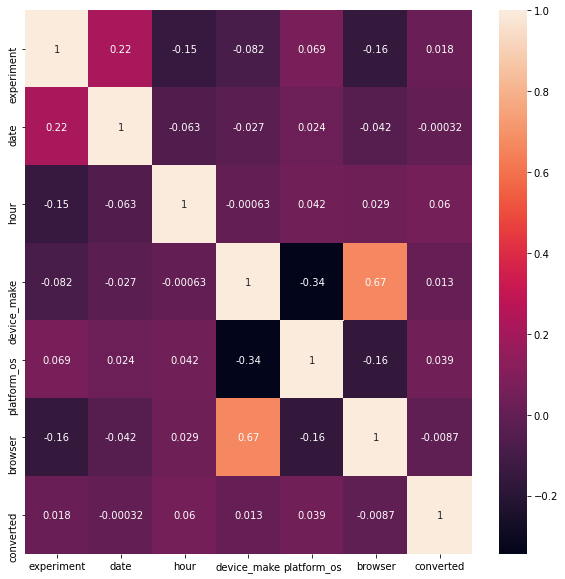

In [11]:
#correlation among the features
corr = df.corr()
top_corr_features = corr.index
plt.figure(figsize=(10,10))
#plot heat map
corr_p= sns.heatmap(df[top_corr_features].corr(), annot= True)

In [12]:
browser_df = df[['experiment', 'hour', 'date','browser', 'converted']]
platfrom_df =df[['experiment', 'hour', 'date', 'platform_os', 'converted']] 

In [13]:
# pd.save_csv(browser_df, "../Data/clean_data.csv")
# pd.save_csv(platfrom_df, "../Data/clean_data.csv")

In [14]:
def split(df):
    train_size=0.7

    train,test= train_test_split(df,train_size=0.7)


    test_size=0.3

    test, valid = train_test_split(test,test_size=0.3 )
    return train,test,valid

    

In [102]:
train_x,test_x, val_x=split(platfrom_df)
train_xx=train_x[['experiment', 'hour', 'date', 'platform_os']]
train_xy=train_x['converted']
val_xx=val_x[['experiment', 'hour', 'date', 'platform_os']]
val_xy=val_x['converted']
test_xx=test_x[['experiment', 'hour', 'date', 'platform_os']]
test_xy= test_x['converted']

train_y,test_y,val_y=split(browser_df)
train_yx=train_y[['experiment', 'hour', 'date', 'browser']]
train_yy=train_y['converted']
val_yx=val_y[['experiment', 'hour', 'date', 'browser']]
val_yy=val_y['converted']
test_yx=test_y[['experiment', 'hour', 'date', 'browser']]
test_yy= test_y['converted']
test_yx
#test_y

,experiment,hour,date,browser
2361,0.0,0.652174,0.000000,0.142857
3433,0.0,0.652174,0.000000,1.000000
6779,0.0,0.391304,0.428571,0.285714
5074,0.0,0.304348,0.428571,0.142857
5858,1.0,0.652174,0.714286,0.285714
...,...,...,...,...
2732,1.0,0.000000,0.571429,0.285714
1977,1.0,0.347826,1.000000,0.285714
1378,1.0,0.086957,1.000000,0.285714
3374,0.0,0.173913,1.000000,0.142857


## Model Training Using logistic regression Model for platform and browser

###  Model Training Using logistic regression Model for platform 

In [16]:
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5)

In [17]:

#train logistic regression model
log_model = LogisticRegression()
log_model.fit(train_xx,train_xy)
#calculate average accuracy score 
print(cross_val_score(log_model, train_xx, train_xy,cv=k_fold, scoring= 'accuracy').mean())

0.5310344827586208


In [18]:
#import log_loss
from sklearn.metrics import log_loss
model = log_model
# predict probabilities
probs = model.predict_proba(val_xx)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss using validation data
loss = log_loss(val_xy, probs)
loss

0.6847350163673901

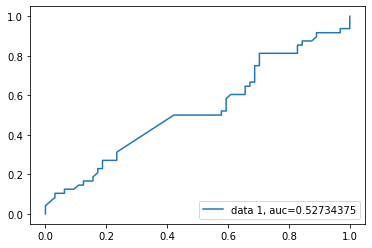

In [19]:
y_pred_proba = log_model.predict_proba(val_xx)[::,1]
fpr, tpr, _ = metrics.roc_curve(val_xy,  y_pred_proba)
auc = metrics.roc_auc_score(val_xy, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [43]:
#predict values using testing data
prediction = log_model.predict(test_xx)
predicted_values = pd.DataFrame({
           "experiment" : test_x['experiment'],
           "converted" : prediction})
predicted_values.head()

,experiment,converted
2731,1.0,0.0
3036,0.0,0.0
4881,1.0,0.0
5354,0.0,0.0
1845,0.0,0.0


In [44]:
#confusion matris
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_xy, prediction)
cnf_matrix

array([[123,  14],
       [106,  18]])

In [45]:
#train decision tree model
dt = DecisionTreeClassifier()
dt.fit(train_xx,train_xy)
print(cross_val_score(dt, train_xx,train_xy,cv= 5, scoring= 'accuracy').mean())

0.5218390804597701


In [48]:
from sklearn.metrics import log_loss
model = dt
# predict probabilities
probs = model.predict_proba(test_xx)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(test_xy, probs)
loss

6.675844687546159

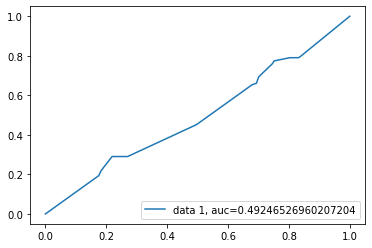

In [50]:
y_pred_proba = dt.predict_proba(test_xx)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_xy,  y_pred_proba)
auc = metrics.roc_auc_score(test_xy, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

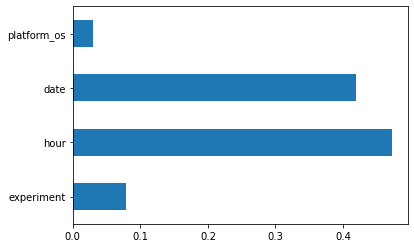

In [52]:
#feature importance
feat_importance = pd.Series(dt.feature_importances_, index=train_xx.columns)
feat_importance.plot(kind='barh')
plt.show()

In [56]:
#predict using testing data
prediction = dt.predict(test_xx)
predicted_values = pd.DataFrame({
           "experiment" : test_x['experiment'],
           "yes" : prediction})
predicted_values.head()

,experiment,yes
2731,1.0,0.0
3036,0.0,0.0
4881,1.0,0.0
5354,0.0,0.0
1845,0.0,0.0


In [57]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_xy, prediction)
cnf_matrix

array([[100,  37],
       [ 88,  36]])

In [ ]:
#train XGBoost 
data_dmatrix = xgb.DMatrix(data=train_xx,label=train_xy)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(train_xx,train_xy)
#calculate average accuracy 
print(cross_val_score(xg_reg, train_xx, train_xy,cv= 5, scoring= 'accuracy').mean())


In [66]:
from sklearn.metrics import log_loss
model = xg_reg
# predict probabilities
probs = model.predict_proba(test_xx)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(test_xy, probs)
loss

0.818092562301063

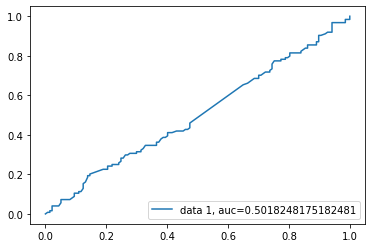

In [68]:
y_pred_proba = xg_reg.predict_proba(test_xx)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_xy,  y_pred_proba)
auc = metrics.roc_auc_score(test_xy, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

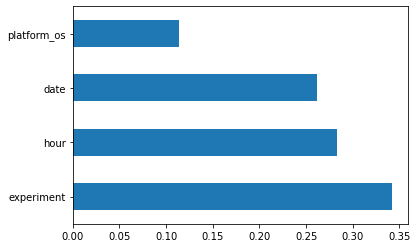

In [70]:
#feature importance for XGBoost model
feat_importance = pd.Series(xg_reg.feature_importances_, index=train_xx.columns)
feat_importance.plot(kind='barh')
plt.show()

In [73]:
#predict using testind data
prediction = xg_reg.predict(test_xx)
submission = pd.DataFrame({
    "experiment" : test_x['experiment'],
    "converted" : prediction
})
submission.head()

,experiment,converted
2731,1.0,0.0
3036,0.0,0.0
4881,1.0,1.0
5354,0.0,0.0
1845,0.0,0.0


In [74]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_xy, prediction)
cnf_matrix

array([[85, 52],
       [77, 47]])

### Model Training Using logistic regression Model for browser

In [76]:
#train logistic regression model
log_model_b = LogisticRegression()
log_model_b.fit(train_yx,train_yy)
#calculate average accuracy score 
print(cross_val_score(log_model_b, train_xx, train_xy,cv=k_fold, scoring= 'accuracy').mean())

0.5172413793103449


In [116]:
#import log_loss
from sklearn.metrics import log_loss
model = log_model
# predict probabilities
probs_b = model.predict_proba(val_yx)
# keep the predictions for class 1 only
probs_b = probs_b[:, 1]
# calculate log loss using validation data
loss_b = log_loss(val_yy, probs_b)
loss_b

0.6999731375293307

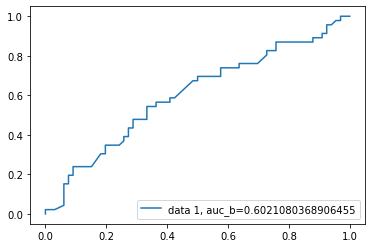

In [87]:
B_pred_proba = log_model.predict_proba(val_yx)[::,1]
fpr_b, tpr_b, _ = metrics.roc_curve(val_yy,  B_pred_proba)
auc_b = metrics.roc_auc_score(val_yy, B_pred_proba)
plt.plot(fpr_b,tpr_b,label="data 1, auc_b="+str(auc_b))
plt.legend(loc=4)
plt.show()

In [88]:
#predict values using testing data
prediction_b = log_model.predict(test_yx)
predicted_values_b = pd.DataFrame({
           "experiment" : test_y['experiment'],
           "converted" : prediction_b})
predicted_values_b.head()

,experiment,converted
7626,0.0,0.0
2904,1.0,0.0
6289,1.0,1.0
5547,1.0,0.0
3337,1.0,0.0


In [89]:
#confusion matris
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_yy, prediction_b)
cnf_matrix

array([[138,   1],
       [121,   1]])

In [90]:
#train decision tree model
dt_b = DecisionTreeClassifier()
dt_b.fit(train_yx,train_yy)
print(cross_val_score(dt_b, train_yx,train_yy,cv= 5, scoring= 'accuracy').mean())

0.5183908045977011


In [91]:
from sklearn.metrics import log_loss
model = dt_b
# predict probabilities
probs = model.predict_proba(test_yx)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss_b = log_loss(test_yy, probs)
loss_b

10.89751874208036

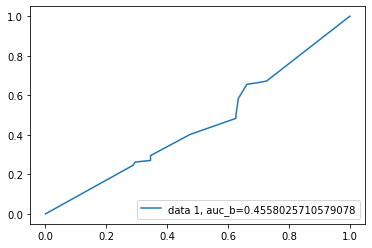

In [92]:
B_pred_proba = dt_b.predict_proba(test_yx)[::,1]
fpr_b, tpr_b, _ = metrics.roc_curve(test_yy,  B_pred_proba)
auc_b = metrics.roc_auc_score(test_yy, B_pred_proba)
plt.plot(fpr_b,tpr_b,label="data 1, auc_b="+str(auc_b))
plt.legend(loc=4)
plt.show()

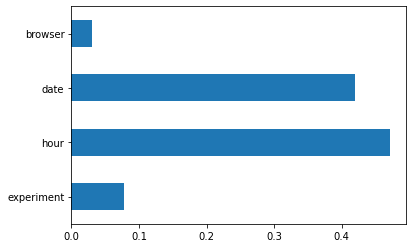

In [109]:
#feature importance
feature_importance = pd.Series(dt.feature_importances_, index=train_yx.columns)
feature_importance.plot(kind='barh')
plt.show()

In [108]:
#predict using testing data
prediction_b = dt_b.predict(test_yx)
predicted_values_b = pd.DataFrame({
           "experiment" : test_y['experiment'],
           "yes" : prediction})
predicted_values_b.head()

,experiment,yes
2361,0.0,0.0
3433,0.0,0.0
6779,0.0,1.0
5074,0.0,0.0
5858,1.0,0.0


In [113]:
#confusion matrix
from sklearn import metrics
cnf_matrix_b = metrics.confusion_matrix(test_yy, prediction_b)
cnf_matrix_b

array([[111,  19],
       [ 58,  73]])

In [115]:
#train XGBoost 
data_dmatrix_b = xgb.DMatrix(data=train_yx,label=train_yy)
xg_reg_b = xgb.XGBClassifier()
xg_reg_b.fit(train_yx,train_yy)
#calculate average accuracy 
print(cross_val_score(xg_reg_b, train_yx, train_yy,cv= 5, scoring= 'accuracy').mean())


[12:03:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:03:57] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: 

In [117]:
from sklearn.metrics import log_loss
model = xg_reg_b
# predict probabilities
probs_b = model.predict_proba(test_yx)
# keep the predictions for class 1 only
probs_b = probs_b[:, 1]
# calculate log loss
loss_b = log_loss(test_yy, probs_b)
loss_b

0.9239384378422537

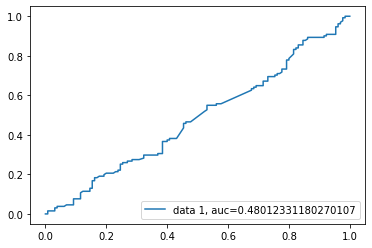

In [118]:
B_pred_proba = xg_reg_b.predict_proba(test_yx)[::,1]
fpr, tpr, _ = metrics.roc_curve(test_yy,  B_pred_proba)
auc = metrics.roc_auc_score(test_yy, B_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

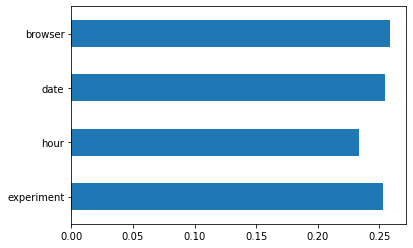

In [119]:
#feature importance for XGBoost model
feat_importance = pd.Series(xg_reg_b.feature_importances_, index=train_yx.columns)
feat_importance.plot(kind='barh')
plt.show()

In [121]:
#predict using testind data
prediction_b = xg_reg_b.predict(test_yx)
submission_b = pd.DataFrame({
    "experiment" : test_y['experiment'],
    "converted" : prediction
})
submission_b.head()

,experiment,converted
2361,0.0,0.0
3433,0.0,1.0
6779,0.0,1.0
5074,0.0,1.0
5858,1.0,1.0


In [122]:
#confusion matrix
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(test_yy, prediction)
cnf_matrix

array([[71, 59],
       [73, 58]])